In [1]:
import pandas as pd

hist = pd.read_csv('historical_data.csv')
fg = pd.read_csv('fear_greed_index.csv')

print("historical shape:", hist.shape)
print("fg shape:", fg.shape)
print("\nhistorical columns:", hist.columns.tolist())
print("\nfg columns:", fg.columns.tolist())

display(hist.head())
display(fg.head())


historical shape: (211224, 16)
fg shape: (2644, 4)

historical columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

fg columns: ['timestamp', 'value', 'classification', 'date']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [2]:
# Parse timestamps
# Historical (ms epoch or datetime string)
if 'Timestamp' in hist.columns:
    hist['time_parsed'] = pd.to_datetime(
        hist['Timestamp'],
        unit='ms' if pd.api.types.is_numeric_dtype(hist['Timestamp']) else None,
        errors='coerce'
    )
else:
    # fallback: first parseable column
    for c in hist.columns:
        parsed = pd.to_datetime(hist[c], errors='coerce')
        if parsed.notna().any():
            hist['time_parsed'] = parsed
            break
hist['trade_date'] = hist['time_parsed'].dt.date

# Fear & Greed (sec epoch or date string)
if 'timestamp' in fg.columns and pd.api.types.is_numeric_dtype(fg['timestamp']):
    fg['date_parsed'] = pd.to_datetime(fg['timestamp'], unit='s', errors='coerce')
elif 'date' in fg.columns:
    fg['date_parsed'] = pd.to_datetime(fg['date'], errors='coerce')
fg['fg_date'] = fg['date_parsed'].dt.date

# Quick ranges and overlap
print("Hist:", hist['time_parsed'].min(), "->", hist['time_parsed'].max())
print("FG:", fg['date_parsed'].min(), "->", fg['date_parsed'].max())
print("Days:", hist['trade_date'].nunique(), "trades;", fg['fg_date'].nunique(), "fg")
overlap = set(hist['trade_date']).intersection(fg['fg_date'])
print("Overlap:", len(overlap))


Hist: 2023-03-28 10:40:00 -> 2025-06-15 15:06:40
FG: 2018-02-01 05:30:00 -> 2025-05-02 05:30:00
Days: 7 trades; 2644 fg
Overlap: 6


In [3]:
# Make sure PnL is numeric
hist['Closed PnL'] = pd.to_numeric(hist['Closed PnL'], errors='coerce')

# Win flag
hist['is_win'] = (hist['Closed PnL'] > 0).astype(int)

# Size in USD (only if column exists)
if 'Size USD' in hist.columns:
    hist['size_usd'] = pd.to_numeric(hist['Size USD'], errors='coerce')

# Buy/Sell flag
if 'side' in hist.columns:
    hist['side_buy'] = hist['side'].str.lower().eq('buy').astype(int)


In [4]:
# Summarize trading data by day
daily = (
    hist
    .groupby('trade_date', as_index=False)  # group by date
    .agg(
        daily_trades=('Account', 'count'),        # number of trades
        daily_total_pnl=('Closed PnL', 'sum'),         # total PnL
        daily_avg_pnl=('Closed PnL', 'mean'),          # average PnL per trade
        daily_win_rate=('is_win', 'mean'),        # fraction of winning trades
        avg_size_usd=('size_usd', 'mean')         # average trade size in USD (NaN if missing)
    )
    .sort_values('trade_date')                     # sort by date
)

# Show the first few rows
display(daily.head())


,trade_date,daily_trades,daily_total_pnl,daily_avg_pnl,daily_win_rate,avg_size_usd
0,2023-03-28,3,0.000000e+00,0.000000,0.000000,159.000000
1,2023-11-14,1045,1.555034e+02,0.148807,0.274641,11057.827522
2,2024-03-09,6962,1.769655e+05,25.418772,0.490089,5660.265764
3,2024-07-03,7141,1.587424e+05,22.229713,0.317182,3058.848110
4,2024-10-27,35241,3.189461e+06,90.504272,0.451605,2949.625864


In [5]:
# Step 1: Rename columns for clarity
fg = fg.rename(columns={
    'value': 'fg_score',           # rename 'value' to 'fg_score' if it exists
    'classification': 'fg_class'   # rename 'classification' to 'fg_class' if it exists
})

# Step 2: Keep only relevant columns and remove duplicates
fg_for_merge = fg[['fg_date', 'fg_score', 'fg_class']].drop_duplicates(subset=['fg_date'])

# Step 3: Merge FG data with daily trading data
merged_daily = pd.merge(
    daily,
    fg_for_merge,
    left_on='trade_date',
    right_on='fg_date',
    how='left'  # keep all daily data, even if FG info is missing
)

# Step 4: Display the first 20 rows
display(merged_daily.head(20))


,trade_date,daily_trades,daily_total_pnl,daily_avg_pnl,daily_win_rate,avg_size_usd,fg_date,fg_score,fg_class
0,2023-03-28,3,0.000000e+00,0.000000,0.000000,159.000000,2023-03-28,59.0,Greed
1,2023-11-14,1045,1.555034e+02,0.148807,0.274641,11057.827522,2023-11-14,69.0,Greed
2,2024-03-09,6962,1.769655e+05,25.418772,0.490089,5660.265764,2024-03-09,84.0,Extreme Greed
3,2024-07-03,7141,1.587424e+05,22.229713,0.317182,3058.848110,2024-07-03,50.0,Neutral
4,2024-10-27,35241,3.189461e+06,90.504272,0.451605,2949.625864,2024-10-27,74.0,Greed
5,2025-02-19,133871,6.699925e+06,50.047622,0.415146,5259.977837,2025-02-19,44.0,Fear
6,2025-06-15,26961,7.170935e+04,2.659744,0.349171,11508.299879,NaN,NaN,NaN


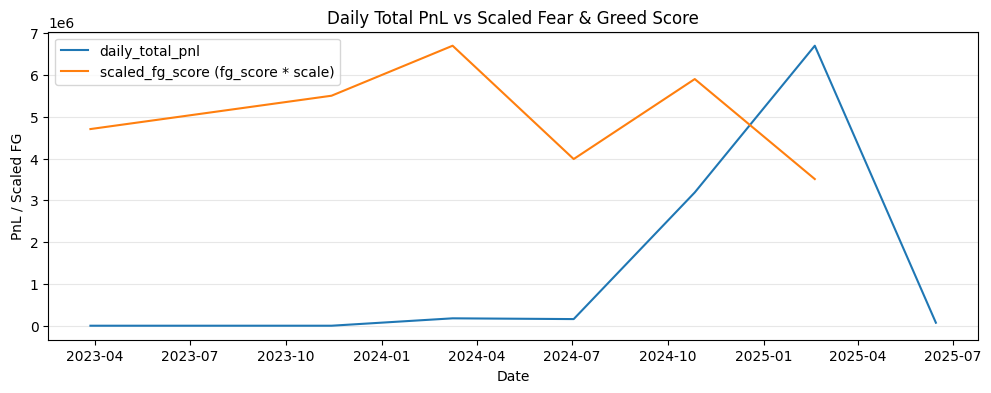

In [6]:
import matplotlib.pyplot as plt

# Step 1: Set up the figure size
plt.figure(figsize=(12, 4))

# Step 2: Plot daily total PnL
plt.plot(
    merged_daily['trade_date'],
    merged_daily['daily_total_pnl'],
    label='daily_total_pnl'
)

# Step 3: If FG scores exist, scale them and overlay
if merged_daily['fg_score'].notna().any():
    # Compute a scaling factor to match FG score to PnL range
    scale = merged_daily['daily_total_pnl'].abs().max() / (merged_daily['fg_score'].max() or 1)
    plt.plot(
        merged_daily['trade_date'],
        merged_daily['fg_score'] * scale,
        label='scaled_fg_score (fg_score * scale)'
    )

# Step 4: Add legend, title, labels, and grid
plt.legend()
plt.title('Daily Total PnL vs Scaled Fear & Greed Score')
plt.xlabel('Date')
plt.ylabel('PnL / Scaled FG')
plt.grid(axis='y', alpha=0.3)

# Step 5: Show the plot
plt.show()


/var/folders/dz/9py5nx5n5hjct1tm3zv41nlw0000gn/T/ipykernel_1697/1887205344.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=classes, showfliers=False)  # hide outliers for clarity


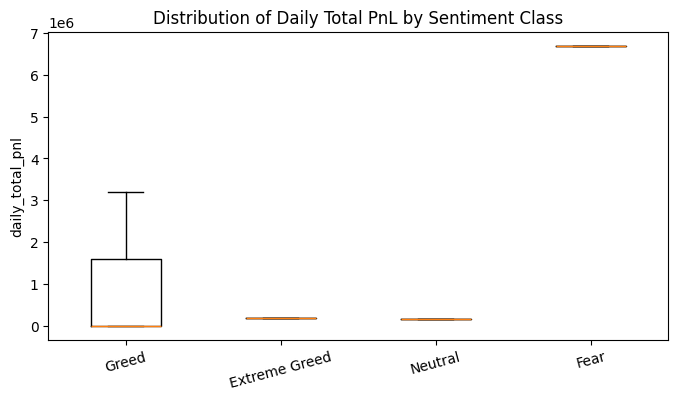

In [7]:
# Step 1: Keep only rows that have both FG class and daily PnL
plot_df = merged_daily.dropna(subset=['fg_class', 'daily_total_pnl'])

# Step 2: Get the unique sentiment classes
classes = plot_df['fg_class'].unique()

# Step 3: Prepare data for the boxplot
# Each element in the list corresponds to daily PnL for one class
data = [plot_df.loc[plot_df['fg_class'] == c, 'daily_total_pnl'] for c in classes]

# Step 4: Create the boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(data, labels=classes, showfliers=False)  # hide outliers for clarity
plt.title('Distribution of Daily Total PnL by Sentiment Class')
plt.ylabel('daily_total_pnl')
plt.xticks(rotation=15)  # rotate class labels for better readability

# Step 5: Display the plot
plt.show()


In [8]:
merged_daily.to_csv('merged_daily.csv', index=False)
print("Saved merged_daily.csv")

Saved merged_daily.csv
